<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>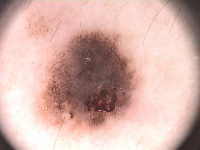</td><td>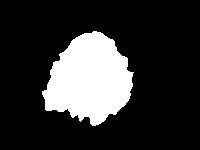</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
# !gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=9d6d1248-90bf-446a-9596-6e05e815429e
To: /content/PH2Dataset.rar
100% 162M/162M [00:01<00:00, 90.4MB/s]


In [ ]:
# get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [1]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [2]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

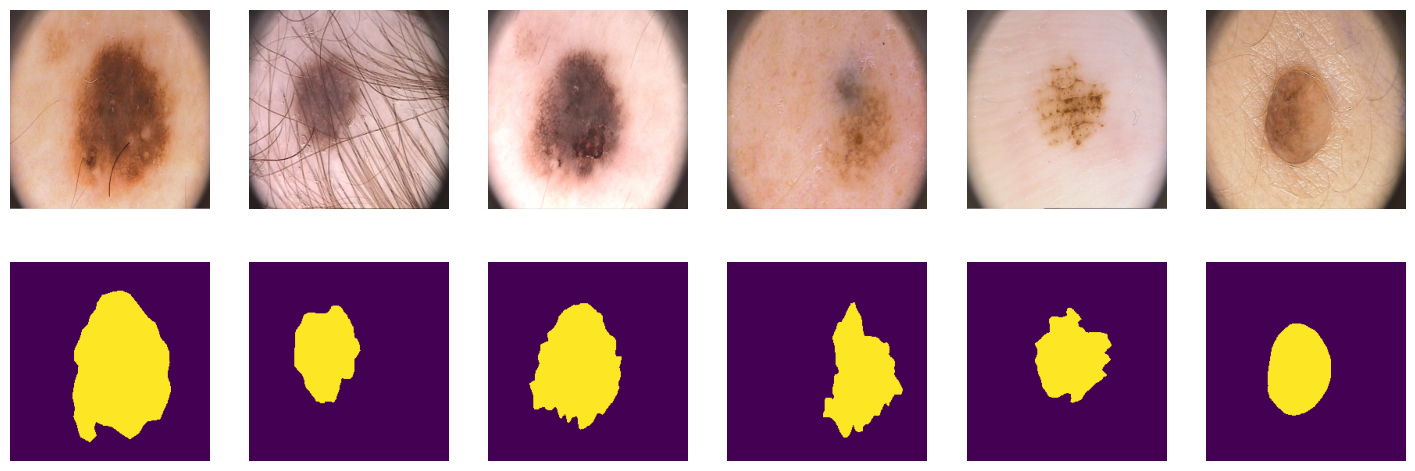

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [5]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [6]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [7]:
from torch.utils.data import DataLoader
batch_size = 20
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [8]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [ ]:
%pip install torchmetrics

   ---------------------------------------- 0.0/961.5 kB ? eta -:--:--
   --------------------- ------------------ 524.3/961.5 kB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 961.5/961.5 kB 5.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

c:\Users\pavel.zubkov\pytorch_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:** 

$$\mathcal -(y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))) =\\
y_i*-log\left(\frac{1}{1+\exp(-\hat y)}\right) +  (1 - y_i) * -\log\left(\frac{\exp(-\hat y)}{1 + \exp(-\hat y)}\right) = \\
y_i \log(1+\exp(-\hat y)) + (1 - y_i)*(-\log(\exp(-\hat y)) + \log(1+\exp(-\hat y) = \\
y_i\log(1+\exp(-\hat y))+(1-y_i)*(\hat y * log(1+\exp(-\hat y))) =\\
(1-y_i) * \hat y + \log(1+\exp(-\hat y)) = \\
\hat y - y_i\hat y + \log(1+\exp(-\hat y))
$$


### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [10]:
import torch.nn.functional as F
import torch.nn as nn

In [11]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [12]:
def bce_loss(y_pred, y_real):
  return torch.sum(y_pred * (1 - y_real) + torch.log(1 + torch.exp(-y_pred)))
  
def bce_true(y_pred, y_real):
  return - torch.sum(y_real * torch.log(torch.sigmoid(y_pred)) + 
               (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred)))

Проверим корректность работы на простом примере

In [13]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 5.516100883483887
BCE loss честно посчитанный = 5.516100883483887
BCE loss from torch bce_torch = 5.516100883483887
BCE loss from torch with logits bce_torch = 5.516100883483887


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [14]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [15]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 12.504584312438965
BCE loss честно посчитанный = 12.504584312438965
BCE loss from torch bce_torch = 12.504584312438965
BCE loss from torch with logits bce_torch = 12.504584312438965


In [16]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [ ]:
# !gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

In [17]:
path_to_dummy_samples = os.path.join("for_asserts")
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

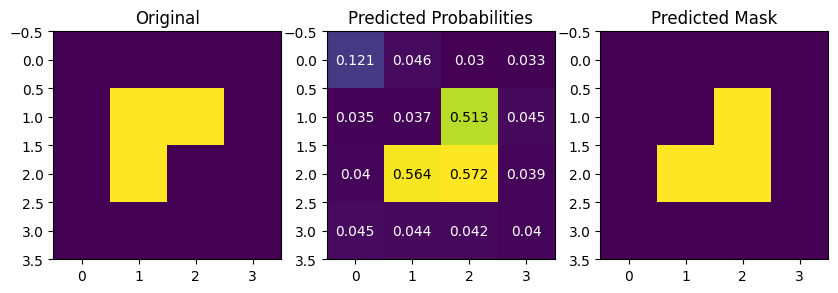

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [19]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

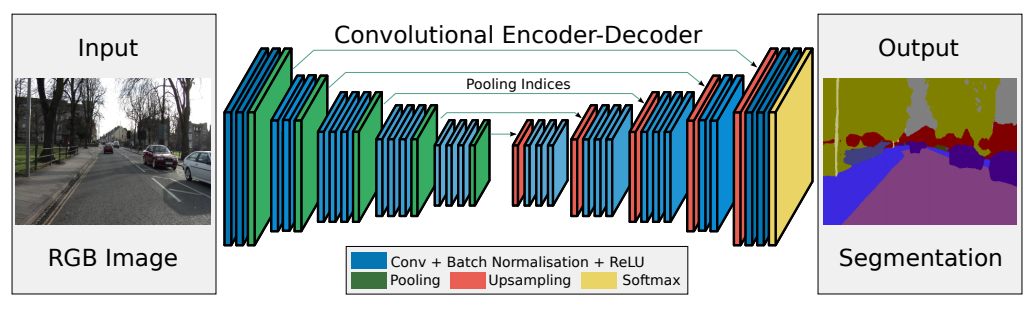

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [21]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # VGG-16 architecture. Encoder.
        self.en_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.en_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.en_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.en_conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.unpool4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        x = self.en_conv1(x)
        x, ind1 = self.pool1(x)
        
        x = self.en_conv2(x)
        x, ind2 = self.pool2(x)
        
        x = self.en_conv3(x)
        x, ind3 = self.pool3(x)
        
        x = self.en_conv4(x)
        x, ind4 = self.pool4(x)

        # bottleneck
        x = self.bottleneck(x)

        # decoder
        x = self.unpool4(x, ind4)
        x = self.dec_conv4(x)
        
        x = self.unpool3(x, ind3)
        x = self.dec_conv3(x)
        
        x = self.unpool2(x, ind2)
        x = self.dec_conv2(x)
        
        x = self.unpool1(x, ind1)
        x = self.dec_conv1(x)

        return x # no activation

In [ ]:
segnet_model = SegNet().to(device)

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [40]:
from tqdm.auto import tqdm

In [41]:
  def score_model(model, metric, data):
      model.eval()
      scores = 0
      for X_batch, Y_label in data:
          with torch.no_grad():
            Y_pred = model(X_batch.to(device))
          Y_pred = (torch.sigmoid(Y_pred)>0.5).int()
          scores += metric(Y_pred.to(device), Y_label.to(device)).mean().item()

      return scores/len(data)

In [ ]:
torch.cuda.empty_cache()

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [38]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader):
    
    best_val_loss = float('inf')
    train_loss_list, val_loss_list, saved_score_list = [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        # Обучение с прогресс-баром
        with tqdm(train_loader, desc='epoch') as pbar:
            for images, masks in pbar:
                images, masks = images.to(device), masks.to(device)
                
                opt.zero_grad()
                outputs = model(images)
                loss = loss_fn(outputs, masks)
                loss.backward()
                opt.step()
                
                train_loss += loss.item()

                pbar.set_postfix({'loss': loss.item()})
        
        # Валидация с прогресс-баром
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc='Validating', leave=False):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_loss += loss_fn(outputs, masks).item()
        
        # Статистика эпохи
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        saved_score_list.append(score_model(model, iou_score, val_loader))

        tqdm.write(f'\nEpoch {epoch+1}/{epochs}')
        tqdm.write(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        
        # Сохранение лучшей модели
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_segnet.pth')
            tqdm.write('Model saved!')
    
    print('Training complete!')
    return train_loss_list, val_loss_list, saved_score_list, model

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(segnet_model.parameters(), lr=1e-4)

tr_loss, v_loss, iou, trained_model = train(
        model=segnet_model,
        opt=optimizer,
        loss_fn=criterion,
        epochs=20,
        train_loader=train_dataloader,
        val_loader=valid_dataloader,
    )

epoch: 100%|██████████| 5/5 [00:58<00:00, 11.63s/it, loss=0.131]



Epoch 1/20
Train Loss: 0.1450 | Val Loss: 0.1444
Model saved!


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.08s/it, loss=0.191]



Epoch 2/20
Train Loss: 0.1368 | Val Loss: 0.1761


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.07s/it, loss=0.136]



Epoch 3/20
Train Loss: 0.1503 | Val Loss: 0.1584


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.12s/it, loss=0.133] 



Epoch 4/20
Train Loss: 0.1179 | Val Loss: 0.1827


epoch: 100%|██████████| 5/5 [00:56<00:00, 11.30s/it, loss=0.0919]



Epoch 5/20
Train Loss: 0.1086 | Val Loss: 0.1640


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.18s/it, loss=0.136] 



Epoch 6/20
Train Loss: 0.1387 | Val Loss: 0.1596


epoch: 100%|██████████| 5/5 [00:56<00:00, 11.26s/it, loss=0.101]



Epoch 7/20
Train Loss: 0.1341 | Val Loss: 0.1299
Model saved!


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.15s/it, loss=0.115] 



Epoch 8/20
Train Loss: 0.1062 | Val Loss: 0.1473


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.11s/it, loss=0.0979]



Epoch 9/20
Train Loss: 0.1020 | Val Loss: 0.1266
Model saved!


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.06s/it, loss=0.109] 



Epoch 10/20
Train Loss: 0.1001 | Val Loss: 0.1234
Model saved!


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.05s/it, loss=0.0848]



Epoch 11/20
Train Loss: 0.1017 | Val Loss: 0.1388


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.11s/it, loss=0.101] 



Epoch 12/20
Train Loss: 0.0933 | Val Loss: 0.1138
Model saved!


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.11s/it, loss=0.0833]



Epoch 13/20
Train Loss: 0.0846 | Val Loss: 0.1115
Model saved!


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.08s/it, loss=0.0703]



Epoch 14/20
Train Loss: 0.0887 | Val Loss: 0.1311


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.17s/it, loss=0.0766]



Epoch 15/20
Train Loss: 0.0951 | Val Loss: 0.1371


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.05s/it, loss=0.083] 



Epoch 16/20
Train Loss: 0.0715 | Val Loss: 0.1248


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.12s/it, loss=0.0849]



Epoch 17/20
Train Loss: 0.0676 | Val Loss: 0.1432


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.10s/it, loss=0.06]  



Epoch 18/20
Train Loss: 0.0625 | Val Loss: 0.1190


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.04s/it, loss=0.0817]



Epoch 19/20
Train Loss: 0.0656 | Val Loss: 0.1262


epoch: 100%|██████████| 5/5 [00:55<00:00, 11.09s/it, loss=0.053] 



Epoch 20/20
Train Loss: 0.0644 | Val Loss: 0.1395
Training complete!


## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [ ]:
def test(model, test_loader, metric, device, checkpoint_path='best_segnet.pth'):
    
    # Загрузка сохраненной модели
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    model.eval()

    # Оценка модели
    test_score = score_model(model, metric, test_loader)

    # Вывод результатов
    print(f"Test Score ({type(metric).__name__}): {test_score:.4f}")
    return test_score

In [ ]:
test_score = test(trained_model, test_dataloader, iou_score, device)

Test Score (BinaryJaccardIndex): 0.8576


In [45]:
def show_loss(train_loss, valid_loss, iou):
    plt.figure(figsize=(12, 8))
    plt.plot(tr_loss, label="train")
    plt.plot(v_loss, label="val")
    plt.plot(iou, label="iou")
    plt.title('Loss')
    plt.xlim([0, len(train_loss)-1])
    plt.grid(True)
    plt.legend()
    plt.show()

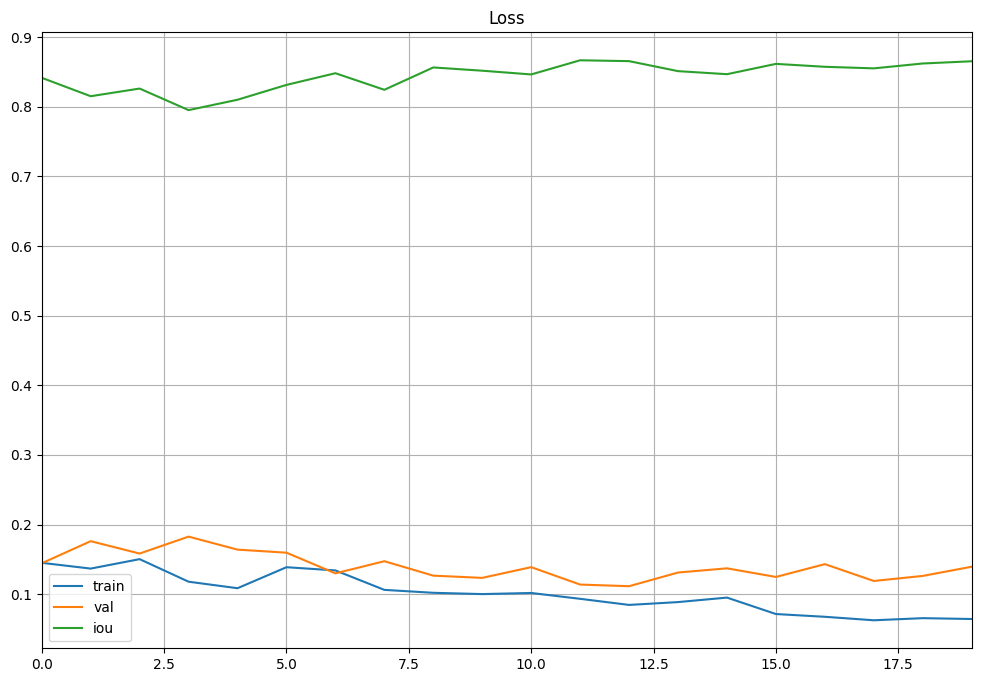

In [ ]:
show_loss(tr_loss, v_loss, iou)

После ~11 эпохи начинает переобучаться.. однако, iou подрастает

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [22]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5, eps: float = 1e-8):
    '''
    Это именно метрика, не лосс.
    '''
     # Бинаризация с сохранением на том же устройстве
    preds = (torch.sigmoid(logits) > threshold).float()
    
    # Вычисляем Dice Score
    intersection = 2 * sum(preds * labels).sum()
    union = (preds + labels).sum()
    
    return (intersection + eps) / (union + eps)

Проверим на корректность функцию dice_score:

In [ ]:
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip show torchmetrics

Name: torchmetrics
Version: 1.7.1
Summary: PyTorch native Metrics
Home-page: https://github.com/Lightning-AI/torchmetrics
Author: Lightning-AI et al.
Author-email: name@pytorchlightning.ai
License: Apache-2.0
Location: c:\Users\pavel.zubkov\pytorch_venv\Lib\site-packages
Requires: lightning-utilities, numpy, packaging, torch
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install --upgrade torchmetrics

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1, average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.4244, device='cuda:0')

In [24]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

AssertionError: 

Вроде всё верно написал, асёрт упорно не проходит т-т

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [25]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):
    logits = torch.sigmoid(logits)
    eps = 1e-8
    num = torch.sum(2*labels*logits)
    den = torch.sum(labels+logits)
    res = 1 - (num + eps)/(den + eps)
    return res.mean()

Проверка на корректность:

In [ ]:
pip install segmentation-models-pytorch

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.4 MB 524.3 kB/s eta 0:00:04
   -------- ------------------------------- 0.5/2.4 MB 524.3 kB/s eta 0:00:04
   ------------- -------------------------- 0.8/2.4 MB 532.8 kB/s eta 0:00:03
   ------------- -------------------------- 0.8/2.4 MB 532.8 kB/s eta 0:00:03
   ----------


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [29]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [34]:
def focal_loss(y_real, y_pred, eps=1e-8, gamma=2):
  y_pred_sigm =  torch.sigmoid(y_pred)
  p_t = y_pred_sigm * y_real + (1 - y_pred_sigm) * (1 - y_real)
  bceloss = (y_pred - (y_real * y_pred) + torch.log(1 + torch.exp(-y_pred)))
  return (bceloss * ((1 - p_t) ** gamma)).sum()

In [112]:
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>

Проверка корректности функции:

In [31]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [35]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

AssertionError: 

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [36]:
def lova_loss(y_real, y_pred):
    y_pred = y_pred.flatten()
    y_real = y_real.flatten()
    signs = 2 * y_real.float() - 1
    errors = (1 - y_pred * signs)
    errors_sorted, indices = torch.sort(errors, dim=0, descending=True)
    gt_sorted = y_real[indices.data]

    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    grad = 1. - intersection / union

    p = len(gt_sorted)
    grad[1:p] = grad[1:p] - grad[0:-1]

    loss = torch.dot(torch.relu(errors_sorted), grad)
    return loss

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [42]:
# focal loss
model_focal = SegNet().to(device)

max_epochs = 20
optimaizer_f = torch.optim.Adam(model_focal.parameters(), lr=1e-4)#, weight_decay=0.3)
train_loss_f, valid_loss_f, score_f, tr_model_f = train(model=model_focal, opt=optimaizer_f, 
                                            loss_fn=focal_loss, epochs=max_epochs, 
                                            train_loader=train_dataloader, val_loader=valid_dataloader,
                                            )
# tr_loss, v_loss, iou, trained_model = train(
#         model=segnet_model,
#         opt=optimizer,
#         loss_fn=criterion,
#         epochs=20,
#         train_loader=train_dataloader,
#         val_loader=valid_dataloader,
#     )

epoch: 100%|██████████| 5/5 [00:20<00:00,  4.03s/it, loss=5.35e+5]



Epoch 1/20
Train Loss: 542565.2625 | Val Loss: 393752.8906
Model saved!


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it, loss=4.61e+5]



Epoch 2/20
Train Loss: 473586.6125 | Val Loss: 391936.3125
Model saved!


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it, loss=3.07e+5]



Epoch 3/20
Train Loss: 369052.4125 | Val Loss: 378875.3073
Model saved!


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it, loss=2.48e+5]



Epoch 4/20
Train Loss: 249372.1688 | Val Loss: 321221.8854
Model saved!


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it, loss=1.78e+5]



Epoch 5/20
Train Loss: 197196.3062 | Val Loss: 405262.9167


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.75s/it, loss=1.74e+5]



Epoch 6/20
Train Loss: 173985.6031 | Val Loss: 326763.3594


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.75s/it, loss=1.58e+5]



Epoch 7/20
Train Loss: 163548.0594 | Val Loss: 257947.0990
Model saved!


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it, loss=1.53e+5]



Epoch 8/20
Train Loss: 157744.1437 | Val Loss: 298915.0521


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.73s/it, loss=1.68e+5]



Epoch 9/20
Train Loss: 160255.7656 | Val Loss: 242513.1354
Model saved!


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it, loss=1.6e+5] 



Epoch 10/20
Train Loss: 153527.1187 | Val Loss: 155785.2760
Model saved!


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it, loss=1.36e+5]



Epoch 11/20
Train Loss: 152982.9062 | Val Loss: 142286.0729
Model saved!


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it, loss=1.37e+5]



Epoch 12/20
Train Loss: 153304.6500 | Val Loss: 146456.5625


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it, loss=1.44e+5]



Epoch 13/20
Train Loss: 152603.9875 | Val Loss: 157516.2552


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it, loss=1.55e+5]



Epoch 14/20
Train Loss: 153038.0719 | Val Loss: 140734.5703
Model saved!


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it, loss=1.54e+5]



Epoch 15/20
Train Loss: 152493.2094 | Val Loss: 133186.6562
Model saved!


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.76s/it, loss=1.5e+5] 



Epoch 16/20
Train Loss: 151616.0406 | Val Loss: 130732.1484
Model saved!


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.82s/it, loss=1.43e+5]



Epoch 17/20
Train Loss: 151467.3719 | Val Loss: 130168.1875
Model saved!


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.73s/it, loss=1.64e+5]



Epoch 18/20
Train Loss: 151546.8031 | Val Loss: 130174.3802


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.80s/it, loss=1.54e+5]



Epoch 19/20
Train Loss: 150869.8156 | Val Loss: 130168.5495


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.80s/it, loss=1.53e+5]



Epoch 20/20
Train Loss: 152124.2594 | Val Loss: 129751.2500
Model saved!
Training complete!


В общем, где-то проблема с масштабированием была, условно делить на 1е-6

In [43]:
score_model(model_focal, iou_score, valid_dataloader)

0.54405677318573

In [49]:
model_dice = SegNet().to(device)

max_epochs = 20
optimaizer_d = torch.optim.Adam(model_focal.parameters(), lr=1e-4)#, weight_decay=0.3)
train_loss_d, valid_loss_d, score_d = train(model_dice, optimaizer_d, dice_loss, max_epochs, train_dataloader, valid_dataloader)

epoch: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it, loss=0.589]



Epoch 1/20
Train Loss: 0.5764 | Val Loss: 0.6337
Model saved!


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it, loss=0.553]



Epoch 2/20
Train Loss: 0.5772 | Val Loss: 0.6071
Model saved!


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it, loss=0.627]



Epoch 3/20
Train Loss: 0.5769 | Val Loss: 0.6220


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it, loss=0.556]



Epoch 4/20
Train Loss: 0.5806 | Val Loss: 0.6110


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it, loss=0.556]



Epoch 5/20
Train Loss: 0.5763 | Val Loss: 0.6341


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it, loss=0.534]



Epoch 6/20
Train Loss: 0.5776 | Val Loss: 0.6071


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.64s/it, loss=0.596]



Epoch 7/20
Train Loss: 0.5790 | Val Loss: 0.6211


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it, loss=0.624]



Epoch 8/20
Train Loss: 0.5757 | Val Loss: 0.6110


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.63s/it, loss=0.564]



Epoch 9/20
Train Loss: 0.5755 | Val Loss: 0.6005
Model saved!


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.64s/it, loss=0.625]



Epoch 10/20
Train Loss: 0.5769 | Val Loss: 0.6262


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it, loss=0.643]



Epoch 11/20
Train Loss: 0.5794 | Val Loss: 0.6144


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it, loss=0.58] 



Epoch 12/20
Train Loss: 0.5776 | Val Loss: 0.6125


epoch: 100%|██████████| 5/5 [00:18<00:00,  3.67s/it, loss=0.56] 



Epoch 13/20
Train Loss: 0.5768 | Val Loss: 0.5991
Model saved!


epoch: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it, loss=0.573]



Epoch 14/20
Train Loss: 0.5769 | Val Loss: 0.5920
Model saved!


epoch: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it, loss=0.594]



Epoch 15/20
Train Loss: 0.5752 | Val Loss: 0.5910
Model saved!


epoch: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it, loss=0.555]



Epoch 16/20
Train Loss: 0.5763 | Val Loss: 0.5942


epoch: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it, loss=0.519]



Epoch 17/20
Train Loss: 0.5800 | Val Loss: 0.6005


epoch: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it, loss=0.581]



Epoch 18/20
Train Loss: 0.5767 | Val Loss: 0.5891
Model saved!


epoch: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it, loss=0.578]



Epoch 19/20
Train Loss: 0.5761 | Val Loss: 0.5897


epoch: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it, loss=0.539]



Epoch 20/20
Train Loss: 0.5770 | Val Loss: 0.6066
Training complete!


ValueError: too many values to unpack (expected 3)

In [50]:
model_lova = SegNet().to(device)

max_epochs = 20
optimaizer_l = torch.optim.Adam(model_focal.parameters(), lr=1e-4)
train_loss_l, valid_loss_l, score_l = train(model_lova, optimaizer_l, lova_loss, max_epochs, train_dataloader, valid_dataloader)

epoch: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, loss=nan]  



Epoch 1/20
Train Loss: nan | Val Loss: 2.0886
Model saved!


epoch: 100%|██████████| 5/5 [00:20<00:00,  4.01s/it, loss=17.4] 



Epoch 2/20
Train Loss: -3.0969 | Val Loss: 2.1816


epoch: 100%|██████████| 5/5 [00:20<00:00,  4.02s/it, loss=2.96] 



Epoch 3/20
Train Loss: 5.7370 | Val Loss: 2.1521


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.99s/it, loss=nan]  



Epoch 4/20
Train Loss: nan | Val Loss: 2.2630


epoch: 100%|██████████| 5/5 [00:20<00:00,  4.01s/it, loss=-35.4]



Epoch 5/20
Train Loss: -3.7263 | Val Loss: 2.2414


epoch: 100%|██████████| 5/5 [00:19<00:00,  4.00s/it, loss=-57.8]



Epoch 6/20
Train Loss: -22.5382 | Val Loss: 3.6376


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, loss=3.52]



Epoch 7/20
Train Loss: 4.2898 | Val Loss: 3.5357


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, loss=nan]  



Epoch 8/20
Train Loss: nan | Val Loss: 2.6806


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, loss=-8.18] 



Epoch 9/20
Train Loss: 3.0519 | Val Loss: 3.2478


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, loss=nan]  



Epoch 10/20
Train Loss: nan | Val Loss: 4.2881


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, loss=12.5] 



Epoch 11/20
Train Loss: 10.4614 | Val Loss: 0.2923
Model saved!


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.99s/it, loss=22.8]



Epoch 12/20
Train Loss: 9.5729 | Val Loss: 1.5314


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, loss=2.36] 



Epoch 13/20
Train Loss: 1.1519 | Val Loss: 5.3852


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, loss=6.94]



Epoch 14/20
Train Loss: -16.1843 | Val Loss: 7.0655


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, loss=4]    



Epoch 15/20
Train Loss: 3.8912 | Val Loss: -0.8396
Model saved!


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, loss=7.41]



Epoch 16/20
Train Loss: 5.5108 | Val Loss: 6.2142


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, loss=-28.6]



Epoch 17/20
Train Loss: -1.4233 | Val Loss: 9.1514


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, loss=4.24] 



Epoch 18/20
Train Loss: 2.3226 | Val Loss: nan


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, loss=3.54]



Epoch 19/20
Train Loss: 4.8750 | Val Loss: -14.3980
Model saved!


epoch: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it, loss=15.5]



Epoch 20/20
Train Loss: 7.6340 | Val Loss: 2.6737
Training complete!


ValueError: too many values to unpack (expected 3)

In [ ]:
Всё, мозг крошится :)

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

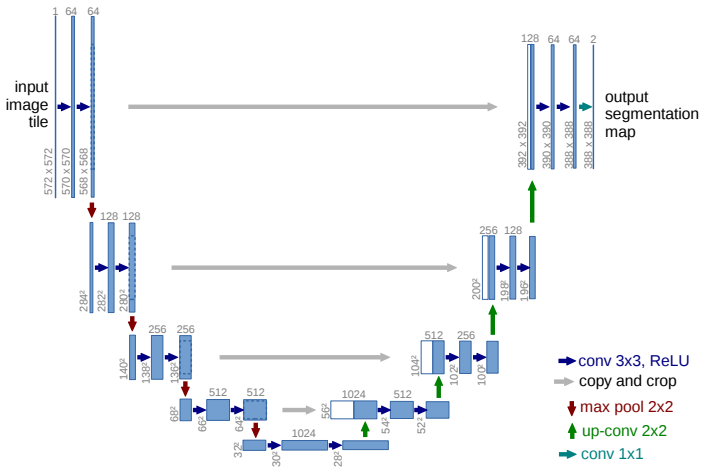

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        # TODO

    def forward(self, x):
        #  TODO

        return output

In [ ]:
unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.

